# Plotting penguin clusters

This notebook covers provides functions that can be used to plot the cluster data produced by the Zooniverse's point reducer code.  The reducer code provides the original point data, probabilities of the points belonging in a cluster, the location of identified clusters, the covariance of the identified clusters, and the lifetimes of identified clusters.

## Import packages used for plotting

These packages are used for plotting (`matplotlib`, `seaborn`), reading in images (`skimage`), reading in data tables (`pandas`), and working with arrays (`scipy` and `numpy`).

In [1]:
from skimage import io
from panoptes_aggregation.csv_utils import unjson_dataframe
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas
import scipy.linalg as sl
import numpy as np
import seaborn as sns

## Using covariance values to draw a 2-$\sigma$ ellipse

The reduction code provides the covariance measurements for the identified clusters, this information can be used to create uncertainty ellipses.  The eigenvalues the covariance matrix give the semi-major and semi-minor axes of the ellipse, and the angle between the eigenvectors gives the angle of the ellipse.  The `matplotlib` ellipse object is returned once these values have been calculated.

In [2]:
def cov_to_ellipse(cov, pos, nstd=1, **kwargs):
    eigvec, eigval, V = sl.svd(cov, full_matrices=False)
    # the angle the first eigenvector makes with the x-axis
    theta = np.degrees(np.arctan2(eigvec[1, 0], eigvec[0, 0]))
    # full width and height of ellipse, not radius
    # the eigenvalues are the variance along the eigenvectors
    width, height = 2 * nstd * np.sqrt(eigval)
    return patches.Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

## Plotting the original subject image

This function takes in the `path` to an image and uses `matplotlib` to display it.  It is displayed using the standard image coordinate system with the origin in the upper left of the image.  This function ensures that the image is plotted in the same size and aspect ratio as the original image.

In [3]:
def display_image_in_actual_size(path):
    im_data = io.imread(path)
    dpi = 100
    height, width, depth = im_data.shape
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)
    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    # Display the image.
    ax.imshow(im_data)
    return fig, ax

## Plotting the data and clusters on the image

The final plotting function puts everything together and plots the original data points and the identified clusters on the original image.  It takes in the `path` to the original image, the `aggregate` data for the image (assumed to a row form a `pandas` data frame).

Each of the four point tools are given a unique color, and the saturation of the points is proportional to the probability of the data point belonging to a cluster (e.g. the closer to grey a point is the more likely it is an outlier).

The transparency of the ellipses is proportional to the lifetime of the identified cluster (e.g. shorter lived clusters are more transparent).

The final cluster counts for each point tool are displayed in the figure's legend.

In [4]:
def plot_points(path, aggregate):
    labels = {
        0: {
            'label': 'Adults',
            'color': '#d62728',
            'count': 0
        },
        1: {
            'label': 'Chicks',
            'color': '#2ca02c',
            'count': 0
        },
        2: {
            'label': 'Eggs',
            'color': '#bcbd22',
            'count': 0
        }
    }
    fig, ax = display_image_in_actual_size(path)
    for tool in labels.keys():
        cluster_x = f'data.frame0.T0_tool{tool}_clusters_x'
        cluster_y = f'data.frame0.T0_tool{tool}_clusters_y'
        cluster_xx = f'data.frame0.T0_tool{tool}_clusters_var_x'
        cluster_yy = f'data.frame0.T0_tool{tool}_clusters_var_y'
        cluster_xy = f'data.frame0.T0_tool{tool}_clusters_var_x_y'
        cluster_prob = f'data.frame0.T0_tool{tool}_clusters_persistance'
        points_x = f'data.frame0.T0_tool{tool}_points_x'
        points_y = f'data.frame0.T0_tool{tool}_points_y'
        points_prob = f'data.frame0.T0_tool{tool}_cluster_probabilities'
        if isinstance(aggregate[cluster_x], list) and isinstance(aggregate[cluster_y], list):
            plot_props = labels[tool]
            probs = np.array(aggregate[cluster_prob])
            max_probs = probs.max()
            props = zip(
                aggregate[cluster_x],
                aggregate[cluster_y],
                aggregate[cluster_xx],
                aggregate[cluster_yy],
                aggregate[cluster_xy],
                aggregate[cluster_prob]
            )
            for x, y, xx, yy, xy, prob in props:
                cov = np.array([[xx, xy], [xy, yy]])
                pos = np.array([x, y])
                color = plot_props['color']
                alpha = 1
                if prob / max_probs <= 0.5:
                    alpha = 0.7
                if prob / max_probs <= 0.1:
                    alpha = 0.3
                ellipse = cov_to_ellipse(
                    cov,
                    pos,
                    nstd=2,
                    edgecolor=color,
                    facecolor='none',
                    lw=2,
                    alpha=alpha
                )
                ax.add_artist(ellipse)
                labels[tool]['count'] += 1
        if isinstance(aggregate[points_x], list) and isinstance(aggregate[points_y], list):
            plot_props = labels[tool]
            colors = [sns.desaturate(plot_props['color'], max(prob, 0.4)) for prob in aggregate[points_prob]]
            ax.scatter(
                aggregate[points_x],
                aggregate[points_y],
                c=colors,
                s=3,
                label='{0} ({1})'.format(plot_props['label'], plot_props['count'])
            )
    plt.legend(loc=1)
    return fig, ax

## Reading in the data

Now that the general plotting functions are defined, we can read in the data.  These lines of code should be adjusted to point to the directories where your data is kept.

`path_reduction`: The file path to the Zooniverse's data reduction file

`base_path_images`: the file path to the original Penguin Watch images (note: the `{0}.png` at the end of this path is important and should not be changed)

In [5]:
path_reduction = 'aggregation_results/point_reducer_hdbscan_example.csv'

reductions = pandas.read_csv(path_reduction)
unjson_dataframe(reductions)

base_path_images = 'Penguin-Watch-Example-data-dumps/penguin-watch-subjects/{0}.png'

## Plotting one image

Here is example code for plotting and displaying one image.  The `iloc[0]` on the first line tells the code to "grab the first row", change the `0` to a different number (up to `49`) to see a different subject.

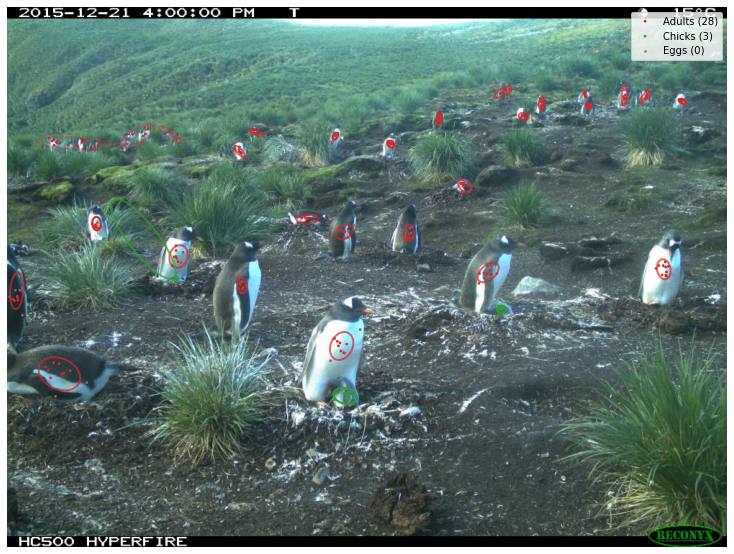

In [6]:
reduction = reductions.iloc[0]
image_path = base_path_images.format(reduction.subject_id)
fig, ax = plot_points(image_path, reduction)
plt.show()

## Plotting all the images

Make a new folder in the `aggregation` directory called `PW_clusters`.  This `for` loop goes through every row of the reduced data, creates the plot, and saves the images to the newly created folder.

In [ ]:
output_path = 'aggregation_results/PW_clusters/{0}_clusters.png'
for sdx, reduction in reductions.iterrows():
    output_name = output_path.format(reduction.subject_id)
    image_path = base_path_images.format(reduction.subject_id)
    fig, ax = plot_points(image_path, reduction)
    fig.savefig(output_name)
    plt.close(fig)